### 小组作业

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms

In [2]:
batch_size = 128
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
learning_rate = 1e-2


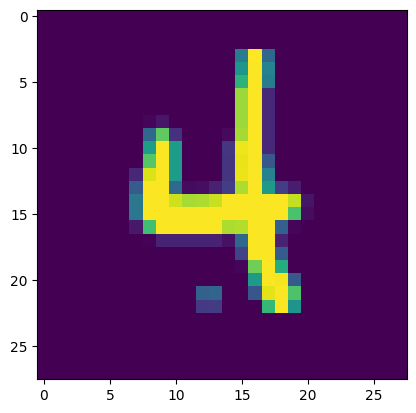

(784, 10000)

In [3]:
# 载入npy文件
data = np.load("train_x.npy")
# 使用Matplotlib可视化数据
ex = data[:,0].reshape((28,28))
plt.imshow(ex)
plt.show()
data.shape

In [4]:
class residual(nn.Module):
    def __init__(self, in_channels):
        super(residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.Relu = nn.ReLU()
    
    def forward(self, x):
        y = self.Relu(self.conv1(x))
        y = self.conv2(y)
        return self.Relu(x+y)

In [5]:
class inception(torch.nn.Module):
    def __init__(self, in_channels):
        super(inception, self).__init__()
        self.branch1 = torch.nn.Conv2d(in_channels, 24, kernel_size=1)
        
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        
        self.branch5x5_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)
        
        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)
    def forward(self, x):
        pool = torch.nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        branch1 = self.branch1(pool(x))
        branch2 = self.branch1x1(x)
        branch3 = self.branch5x5_2(self.branch5x5_1(x))
        branch4 = self.branch3x3_3(self.branch3x3_2(self.branch3x3_1(x)))
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, dim=1)

In [6]:
class convolution(nn.Module):
    def __init__(self, in_channels, channels):
        super(convolution, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=5, stride=2, padding=2)
        
        self.batch1 = nn.BatchNorm2d(channels)
        self.batch2 = nn.BatchNorm2d(channels)
        self.batch3 = nn.BatchNorm2d(channels)
        
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.batch3(x)
        x = self.drop(x)
        
        return x

In [7]:
class tran_convolution(nn.Module):
    def __init__(self, in_channels, channels, x):
        super(tran_convolution, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, channels, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(channels, channels, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=1)
        
        self.batch1 = nn.BatchNorm2d(channels)
        self.batch2 = nn.BatchNorm2d(channels)
        self.batch3 = nn.BatchNorm2d(channels)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.batch3(x)
        
        return x

In [8]:
class SharedEncoder(nn.Module):
    def __init__(self):
        super(SharedEncoder, self).__init__()
        self.conv1 = convolution(1, 32)
        self.conv2 = convolution(32, 64)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


In [9]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        
        # 创建共享的卷积部分
        self.shared_encoder = SharedEncoder()
        
        # 创建第一个网络的独有部分
        self.autoencoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),  # (b, 16, 7, 7)
            nn.ReLU(),
            nn.BatchNorm2d(64),
#             residual(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),  # (b, 16, 7, 7)
            nn.ReLU(),
            nn.BatchNorm2d(32),
#             residual(32),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=1),  # (b, 1, 14, 14)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=4, padding=1),  # (b, 1, 14, 14)
            nn.Sigmoid()
        )
        
        # 创建第二个网络的独有部分
        self.cnn = nn.Sequential(
#             nn.Dropout(0.4),  # 添加Dropout层
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),  # 添加Dropout层
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.4),  # 添加Dropout层
#             nn.Linear(500, 256),
#             nn.ReLU(),
#             nn.Dropout(0.4),  # 添加Dropout层
            nn.Linear(128, 10),
        )
        
        self.flat = nn.Flatten()
        self.rblock1 = residual(64)
        self.rblock2 = residual(16)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
        self.batch1 = nn.BatchNorm2d(64)
        self.batch2 = nn.BatchNorm2d(128)
        
        
        self.tran_conv1 = tran_convolution(64, 32, 3)
        self.tran_conv2 = tran_convolution(32, 1, 4)
    def forward_1(self, x):
        # 前向传播过程
        
        # 共享卷积部分
        shared_output = self.shared_encoder(x)

        # 第一个网络的独有部分
#         decode = self.autoencoder(shared_output)
        decode = self.tran_conv2(self.tran_conv1(shared_output))
        
#         #扁平化
#         shared_output = self.rblock(shared_output)
#         shared_output = self.flat(shared_output)
        
#         # 第二个网络的独有部分
#         cnn_output = self.cnn(shared_output)
        
        return decode
    
    def forward_2(self, x):
        # 前向传播过程
        
        # 共享卷积部分
        shared_output = self.shared_encoder(x)

#         # 第一个网络的独有部分
#         decode = self.autoencoder(shared_output)
        
        #扁平化
#         shared_output = self.rblock1(shared_output)
#         shared_output = self.batch1(shared_output)
        shared_output = self.flat(shared_output)
        
        # 第二个网络的独有部分
        cnn_output = self.cnn(shared_output)
        
        return cnn_output

In [10]:
transform_BZ = transforms.Normalize((0.1307, ), (0.3081))

In [11]:
transform = transforms.Compose([
    
    transforms.Normalize((0.1307, ), (0.3081)),
])

In [12]:
#数据加载转换tensor类
class CNN_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


In [13]:
import numpy as np
from scipy.ndimage import rotate
def augment_data(images):
    augmented_images = []

    for i in range(images.shape[1]):
        image = images[:, i].reshape(28, 28)

        # Move image one pixel to the left
#         moved_left_1 = np.roll(image, -3, axis=1)
#         augmented_images.append(moved_left_1.flatten().reshape(-1, 1))

#         # Move image one pixel to the right
#         moved_right_1 = np.roll(image, 3, axis=1)
#         augmented_images.append(moved_right_1.flatten().reshape(-1, 1))

#         # Move image one pixel up
#         moved_up_1 = np.roll(image, -3, axis=0)
#         augmented_images.append(moved_up_1.flatten().reshape(-1, 1))

#         # Move image one pixel down
#         moved_down_1 = np.roll(image, 3, axis=0)
#         augmented_images.append(moved_down_1.flatten().reshape(-1, 1))

        # Move image two pixels to the left
        moved_left_2 = np.roll(image, -2, axis=1)
        augmented_images.append(moved_left_2.flatten().reshape(-1, 1))

        # Move image two pixels to the right
        moved_right_2 = np.roll(image, 2, axis=1)
        augmented_images.append(moved_right_2.flatten().reshape(-1, 1))

        # Move image two pixels up
        moved_up_2 = np.roll(image, -2, axis=0)
        augmented_images.append(moved_up_2.flatten().reshape(-1, 1))

        # Move image two pixels down
        moved_down_2 = np.roll(image, 2, axis=0)
        augmented_images.append(moved_down_2.flatten().reshape(-1, 1))

        # Rotate image
        rotated_image = rotate(image, np.random.uniform(-3, 3), cval=0.01, reshape=False)
        augmented_images.append(rotated_image.flatten().reshape(-1, 1))
        
        # Rotate image
        rotated_image = rotate(image, np.random.uniform(-3, 3), cval=0.01, reshape=False)
        augmented_images.append(rotated_image.flatten().reshape(-1, 1))
        
        # Rotate image
        rotated_image = rotate(image, np.random.uniform(-3, 3), cval=0.01, reshape=False)
        augmented_images.append(rotated_image.flatten().reshape(-1, 1))

    augmented_images = np.hstack(augmented_images)

    return augmented_images

def augment_data1(images, labels):
    augmented_images = []
    augmented_labels = []

    for i in range(images.shape[1]):
        image = images[:, i].reshape(28, 28)
        label = labels[i]

        # Move image one pixel to the left
#         moved_left_1 = np.roll(image, -3, axis=1)
#         augmented_images.append(moved_left_1.flatten().reshape(-1, 1))
#         augmented_labels.append(label)

#         # Move image one pixel to the right
#         moved_right_1 = np.roll(image, 3, axis=1)
#         augmented_images.append(moved_right_1.flatten().reshape(-1, 1))
#         augmented_labels.append(label)

#         # Move image one pixel up
#         moved_up_1 = np.roll(image, -3, axis=0)
#         augmented_images.append(moved_up_1.flatten().reshape(-1, 1))
#         augmented_labels.append(label)

#         # Move image one pixel down
#         moved_down_1 = np.roll(image, 3, axis=0)
#         augmented_images.append(moved_down_1.flatten().reshape(-1, 1))
#         augmented_labels.append(label)

        # Move image two pixels to the left
        moved_left_2 = np.roll(image, -2, axis=1)
        augmented_images.append(moved_left_2.flatten().reshape(-1, 1))
        augmented_labels.append(label)

        # Move image two pixels to the right
        moved_right_2 = np.roll(image, 2, axis=1)
        augmented_images.append(moved_right_2.flatten().reshape(-1, 1))
        augmented_labels.append(label)

        # Move image two pixels up
        moved_up_2 = np.roll(image, -2, axis=0)
        augmented_images.append(moved_up_2.flatten().reshape(-1, 1))
        augmented_labels.append(label)

        # Move image two pixels down
        moved_down_2 = np.roll(image, 2, axis=0)
        augmented_images.append(moved_down_2.flatten().reshape(-1, 1))
        augmented_labels.append(label)

        # Rotate image
        rotated_image = rotate(image, np.random.uniform(-8, 8), cval=0.01, reshape=False)
        augmented_images.append(rotated_image.flatten().reshape(-1, 1))
        augmented_labels.append(label)
        
        # Rotate image
        rotated_image = rotate(image, np.random.uniform(-8, 8), cval=0.01, reshape=False)
        augmented_images.append(rotated_image.flatten().reshape(-1, 1))
        augmented_labels.append(label)
        
        # Rotate image
        rotated_image = rotate(image, np.random.uniform(-8, 8), cval=0.01, reshape=False)
        augmented_images.append(rotated_image.flatten().reshape(-1, 1))
        augmented_labels.append(label)

    augmented_images = np.hstack(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels





In [14]:



train_y , test_y = np.load("train_y.npy"),np.load("test_y.npy")
train_x , test_x = np.load("train_x.npy"),np.load("test_x.npy")

train_x , train_y = augment_data1(train_x,train_y)
test_x , test_y = augment_data1(test_x,test_y)

train_x = train_x.T.reshape((-1,1,28, 28))/255.0
test_x = test_x.T.reshape((-1,1,28, 28))/255.0

unlabel_train_x = np.load("unlabel_x.npy")
unlabel_train_x = augment_data(unlabel_train_x).T.reshape((-1,1,28, 28))/255.0

final_x = np.load("final_x.npy").T.reshape((-1,1,28, 28))/255.0

train_dataset, test_dataset = CNN_Dataset(
    train_x, train_y), CNN_Dataset(test_x, test_y)

unlabel_train_dataset =  CNN_Dataset(unlabel_train_x)

final_dataset = CNN_Dataset(final_x)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

unlabel_train_loader = DataLoader(
    unlabel_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

final_loader =  DataLoader(
    final_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


In [15]:
model = CombinedModel().to(device)
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-2)



In [16]:

#训练
def untrainer(unlabel_train_loader, model, n_epochs, device):
    un_loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        if epoch in [n_epochs * 0.25, n_epochs * 0.5]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        for i, x in enumerate(unlabel_train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            decode = model.forward_1(x)
            loss = criterion2(x, decode)
            loss.backward()
            optimizer.step()
            un_loss_record.append(loss.detach().item())
            
            if (i + 1) % 25 == 0:  # Print loss every 10 batches
                mean_unlabel_loss = sum(un_loss_record) / len(un_loss_record)
                print(f'Epoch [{epoch+1}/{n_epochs}], Batch [{i+1}/{len(unlabel_train_loader)}]: unlabelTrain loss: {mean_unlabel_loss:.8f}')
        mean_unlabel_loss = sum(un_loss_record) / len(un_loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: unlabelTrain loss: {mean_unlabel_loss:.8f}')
    return un_loss_record

def trainer(train_loader, model, n_epochs, device):
    loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        
        if epoch in [n_epochs * 0.25, n_epochs * 0.5, n_epochs * 0.75]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            pred = model.forward_2(x)
            loss = criterion1(pred, y)
            loss.backward()
            optimizer.step()
            loss_record.append(loss.detach().item())
            
            if (i + 1) % 25 == 0:
                mean_train_loss = sum(loss_record) / len(loss_record)
                print(f'Epoch [{epoch+1}/{n_epochs}], Batch [{i+1}/{len(train_loader)}]: labelTrain loss: {mean_train_loss:.8f}')
        
        mean_train_loss = sum(loss_record) / len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: labelTrain loss: {mean_train_loss:.8f}')
        test(test_loader,model,device)
    return loss_record


In [17]:
def test(test_loader,model,device):
    model.eval()  # Set your model to evaluation mode.
    loss_record = []
    predictions = []  # 用于存储预测值的列表
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        with torch.no_grad():
            pred = model.forward_2(x)
            _, predicted_labels = torch.max(pred.data, 1)  # 获取预测的标签
            predictions.extend(predicted_labels.cpu().numpy())  # 将预测值添加到列表中
            total += y.size(0)  # 累计总样本数量
            correct += (predicted_labels == y).sum().item()  # 统计正确预测的样本数量
            loss = criterion1(pred, y)
        loss_record.append(loss.item())
    mean_test_loss = sum(loss_record)/len(loss_record)
    accuracy = correct / total  # 计算准确率
    print(f'Test loss: {mean_test_loss:.8f}')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return predictions

In [18]:
def final(final_loader,model,device):
    model.eval()  # Set your model to evaluation mode.
    predictions = []  # 用于存储预测值的列表
    for x in final_loader:
        x = x.to(device)
        with torch.no_grad():
            pred = model.forward_2(x)
            _, predicted_labels = torch.max(pred.data, 1)  # 获取预测的标签
            predictions.extend(predicted_labels.cpu().numpy())  # 将预测值添加到列表中
    return predictions

Epoch [1/3], Batch [25/1094]: unlabelTrain loss: 0.55179509
Epoch [1/3], Batch [50/1094]: unlabelTrain loss: 0.37342865
Epoch [1/3], Batch [75/1094]: unlabelTrain loss: 0.27309253
Epoch [1/3], Batch [100/1094]: unlabelTrain loss: 0.21240739
Epoch [1/3], Batch [125/1094]: unlabelTrain loss: 0.17346095
Epoch [1/3], Batch [150/1094]: unlabelTrain loss: 0.14694977
Epoch [1/3], Batch [175/1094]: unlabelTrain loss: 0.12784551
Epoch [1/3], Batch [200/1094]: unlabelTrain loss: 0.11342828
Epoch [1/3], Batch [225/1094]: unlabelTrain loss: 0.10215762
Epoch [1/3], Batch [250/1094]: unlabelTrain loss: 0.09307296
Epoch [1/3], Batch [275/1094]: unlabelTrain loss: 0.08558697
Epoch [1/3], Batch [300/1094]: unlabelTrain loss: 0.07930470
Epoch [1/3], Batch [325/1094]: unlabelTrain loss: 0.07395393
Epoch [1/3], Batch [350/1094]: unlabelTrain loss: 0.06934183
Epoch [1/3], Batch [375/1094]: unlabelTrain loss: 0.06533143
Epoch [1/3], Batch [400/1094]: unlabelTrain loss: 0.06179742
Epoch [1/3], Batch [425/109

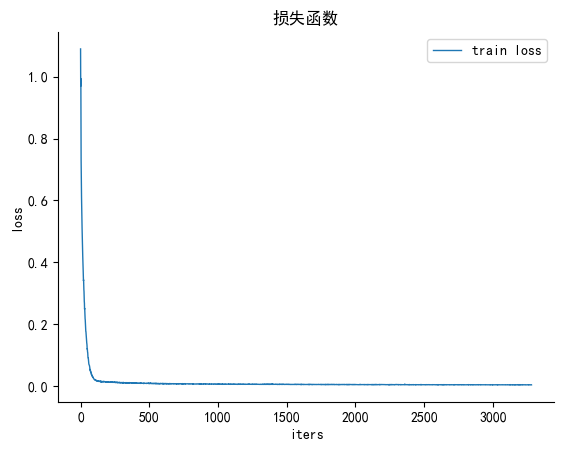

In [19]:
y_train_loss = untrainer(unlabel_train_loader,model,n_epochs-7,device)     # loss值，即y轴
x_train_loss = range(len(y_train_loss))			 # loss的数量，即x轴
plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
plt.plot(x_train_loss, y_train_loss, linewidth=1,linestyle="solid", label="train loss")
plt.legend()
plt.title("损失函数")
plt.show()

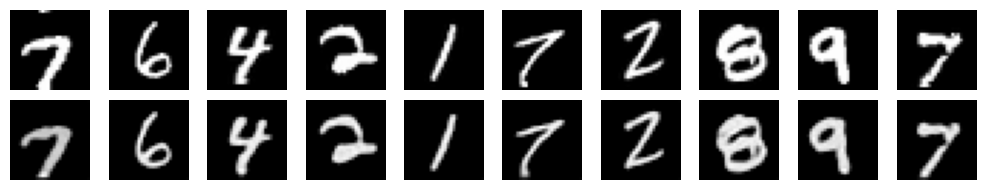

In [20]:
images = next(iter(unlabel_train_loader))
images = images.reshape(-1, 1, 28, 28)
images = images.to('cuda:0')  # 将输入数据移动到 GPU 上
reconstructed_images = model.forward_1(images)

# 将张量转换为图像并显示
original_images = images.view(-1, 1, 28, 28).cpu().detach().numpy()
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28).cpu().detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 2))

# 显示原始图像
for i, ax in enumerate(axes[0]):
    ax.imshow(original_images[i].squeeze(), cmap='gray')
    ax.axis('off')

# 显示重构图像
for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [21]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

Epoch [1/40], Batch [25/547]: labelTrain loss: 0.91295625
Epoch [1/40], Batch [50/547]: labelTrain loss: 0.61739533
Epoch [1/40], Batch [75/547]: labelTrain loss: 0.49406277
Epoch [1/40], Batch [100/547]: labelTrain loss: 0.42129606
Epoch [1/40], Batch [125/547]: labelTrain loss: 0.37626296
Epoch [1/40], Batch [150/547]: labelTrain loss: 0.33816782
Epoch [1/40], Batch [175/547]: labelTrain loss: 0.31130611
Epoch [1/40], Batch [200/547]: labelTrain loss: 0.28969776
Epoch [1/40], Batch [225/547]: labelTrain loss: 0.27257997
Epoch [1/40], Batch [250/547]: labelTrain loss: 0.25803992
Epoch [1/40], Batch [275/547]: labelTrain loss: 0.24448569
Epoch [1/40], Batch [300/547]: labelTrain loss: 0.23285117
Epoch [1/40], Batch [325/547]: labelTrain loss: 0.22288688
Epoch [1/40], Batch [350/547]: labelTrain loss: 0.21389397
Epoch [1/40], Batch [375/547]: labelTrain loss: 0.20637960
Epoch [1/40], Batch [400/547]: labelTrain loss: 0.20011099
Epoch [1/40], Batch [425/547]: labelTrain loss: 0.19329260


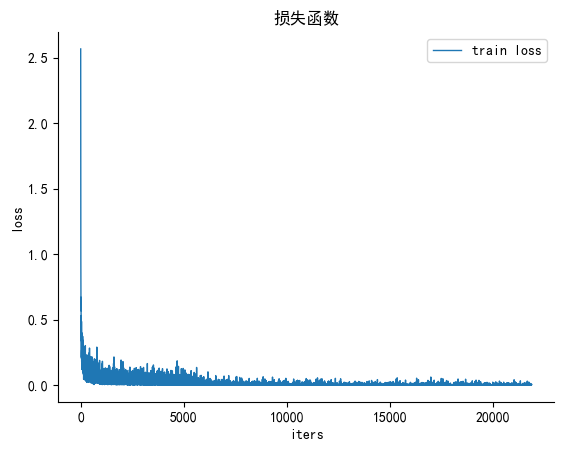

In [22]:
y_train_loss = trainer(train_loader,model,n_epochs+30, device)     # loss值，即y轴
x_train_loss = range(len(y_train_loss))			 # loss的数量，即x轴
plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
plt.plot(x_train_loss, y_train_loss, linewidth=1,linestyle="solid", label="train loss")
plt.legend()
plt.title("损失函数")
plt.show()

Test loss: 0.02890292
Accuracy: 99.37%


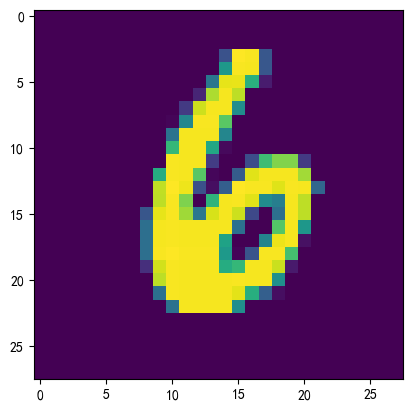

6


In [23]:
predict = test(test_loader,model,device)

ex = np.load("test_x.npy").T[0].reshape((28, 28))
plt.imshow(ex)
plt.show()
print(predict[0])
#成功预测


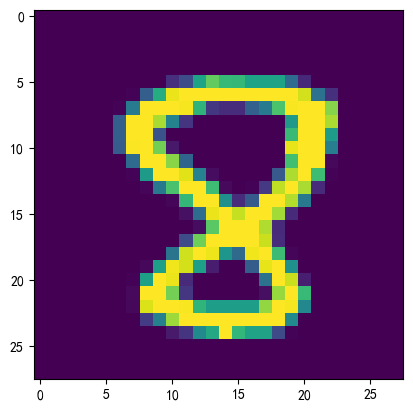

8


In [24]:
finalpre = final(final_loader,model,device)
data = np.load("final_x.npy")
ex = data.T[0].reshape((28, 28))
plt.imshow(ex)
plt.show()
print(finalpre[0])
#成功预测
np.save("final_y.npy",finalpre)